# 1. Imports

In [2]:
import pandas as pd # dataframes
from sklearn.preprocessing import RobustScaler # scale to zero mean and unit variance
from sklearn.decomposition import PCA # primary component analysis
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt # plots
from sklearn import set_config # return pd.DataFrame from transformers
import pickle # move transformers and estimators between notebooks

# custom helper functions
from helper_functions import feature_distribution_plot, scree_plot, decision_boundary_plot

<hr>

# 2. Settings

In [3]:
set_config(transform_output='pandas')

<hr>

# 3. Preprocess the Data Set

In [4]:
df = pd.read_csv('./data/hcvdat33_Complete.csv')

In [6]:
df.drop(columns=['Unnamed: 0', 'Sex'], inplace=True)

In [8]:
df['Category'] = df['Category'].apply(lambda x: int(x[0]) if x and x[0].isdigit() else -1)


,Category,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0,32,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...
610,3,62,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,3,64,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
612,3,64,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
613,3,46,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


In [9]:
df_nas = df.isnull()
df_nas_sum = df_nas.sum()
print("Sum of NAs in data:")
print(df_nas_sum)

Sum of NAs in data:
Category     0
Age          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64


<hr>

# 4 Impute Data

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [13]:
df_imputed = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10)).fit_transform(df)
df_imputed

/Users/Anna/anaconda3/envs/anna/lib/python3.12/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Category,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0.0,32.0,38.5,52.50,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0.0,32.0,38.5,70.30,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0.0,32.0,46.9,74.70,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0.0,32.0,43.2,52.00,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0.0,32.0,39.2,74.10,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...
610,3.0,62.0,32.0,416.60,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,3.0,64.0,24.0,102.80,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
612,3.0,64.0,29.0,87.30,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
613,3.0,46.0,33.0,53.61,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


<hr>

# 5. Train Decision Tree Classifier

Accuracy: 0.8699186991869918
Decision Tree Rules:
 |--- AST <= 54.15
|   |--- CHE <= 12.30
|   |   |--- ALP <= 33.65
|   |   |   |--- GGT <= 18.60
|   |   |   |   |--- Age <= 33.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Age >  33.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- GGT >  18.60
|   |   |   |   |--- CHOL <= 3.35
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- CHOL >  3.35
|   |   |   |   |   |--- class: 1
|   |   |--- ALP >  33.65
|   |   |   |--- CREA <= 306.45
|   |   |   |   |--- CREA <= 123.00
|   |   |   |   |   |--- ALT <= inf
|   |   |   |   |   |   |--- CREA <= 116.50
|   |   |   |   |   |   |   |--- GGT <= 91.80
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- GGT >  91.80
|   |   |   |   |   |   |   |   |--- ALP <= 51.70
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- ALP >  51.70
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- CREA >  11

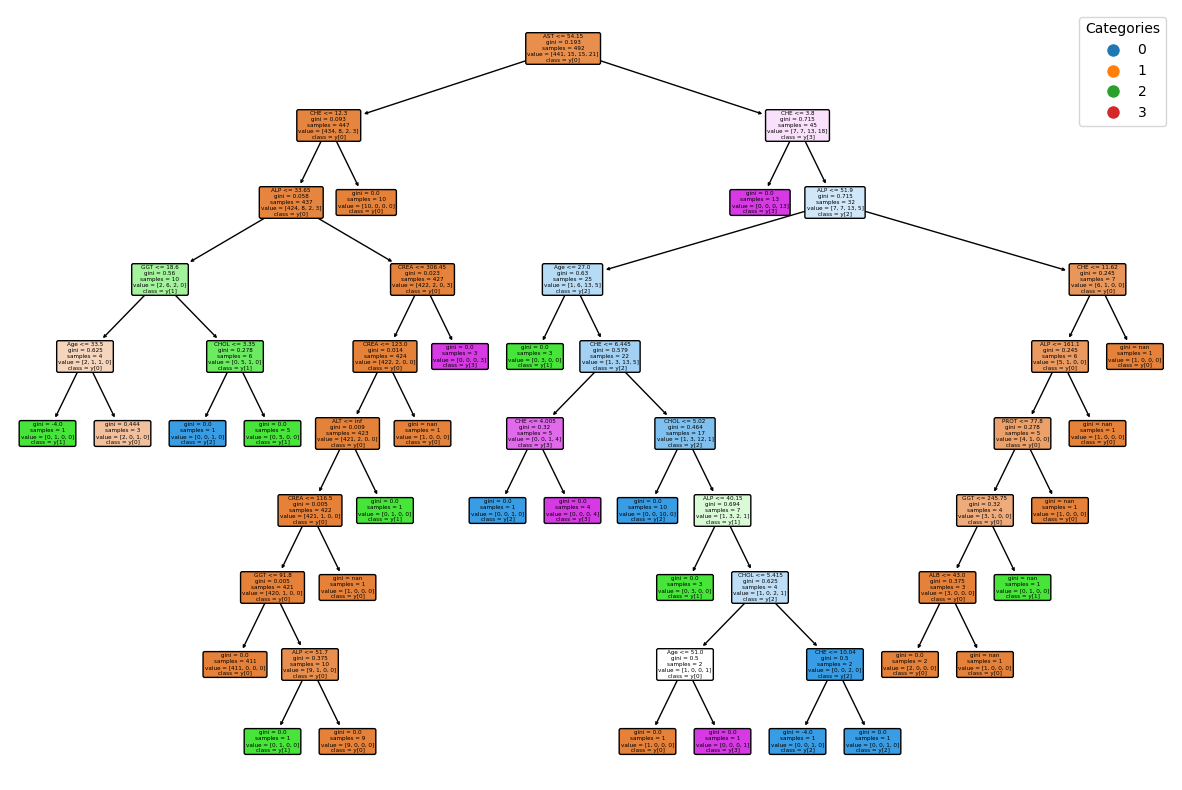

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Assuming df is your DataFrame
# Extract features and target variable
X = df.drop(columns="Category",axis=1) # Features (excluding the target column)
y = df[["Category"]] # Target variable 

# Convert categories to numeric labels for color mapping
label_encoder = preprocessing.LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Visualize the decision tree structure
tree_rules = export_text(clf, feature_names=list(X.columns))
print("Decision Tree Rules:\n", tree_rules)

# Plot the decision tree with a custom legend
plt.figure(figsize=(15, 10))
plot_tree(clf, filled=True, feature_names=list(X.columns), class_names=True, rounded=True, proportion=False)

# Create a legend based on the unique categories and their associated colors
legend_labels = label_encoder.inverse_transform(clf.classes_)  # Get original category names
colors = [f'C{i}' for i in range(len(legend_labels))]

# Add a custom legend to the plot
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                     markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, colors)]
plt.legend(handles=handles, title='Categories', loc='upper right')

plt.show()

